In [ ]:
import os
import time
import json
import requests
import random
import numpy as np
import pandas as pd
from glob import glob
import cv2
import seaborn as sns
from PIL import Image
import matplotlib.pylab as plt
import matplotlib.patches as patches
from io import BytesIO

## Загрузка папок

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module_2/df_1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module_2/df_2.csv')

In [ ]:
path_to_images = "/content/drive/MyDrive/Colab Notebooks/Module_2/plane_ships/"
df_1['filename'] , df_2['filename']= path_to_images + df_1['filename'], path_to_images + df_2['filename']

## Определение набора данных

df_1, сделанный VAN:
длина: 34


df_2, сделанный Joel:
Длина 34

In [ ]:
df_1.shape, df_2.shape

((34, 7), (34, 7))

## Предварительная обработка данных из маркировки.

In [ ]:
print(df_1['region_shape_attributes'][0], df_1['region_attributes'][0])
print(df_2['region_shape_attributes'][0], df_2['region_attributes'][0])

{"name":"rect","x":113,"y":68,"width":81,"height":37} {"label":"ship"}
{"name":"rect","x":19,"y":161,"width":1168,"height":677} {"label":"plane"}


In [ ]:
def process_dataframe(df):
    df['region_shape_attributes'] = df['region_shape_attributes'].apply(json.loads)
    df['region_attributes'] = df['region_attributes'].apply(json.loads)

    df['file_name'] = df['filename']
    df['x'] = df['region_shape_attributes'].apply(lambda x: x['x'])
    df['y'] = df['region_shape_attributes'].apply(lambda x: x['y'])
    df['width'] = df['region_shape_attributes'].apply(lambda x: x['width'])
    df['height'] = df['region_shape_attributes'].apply(lambda x: x['height'])
    df['labels'] = df['region_attributes'].apply(lambda x: x['label'])

    df_processed = df[['file_name', 'region_count', 'region_id', 'x', 'y', 'width', 'height', 'labels']]

    return df_processed

df_1 = process_dataframe(df_1)
df_2 = process_dataframe(df_2)

## Сравнение двух работ

In [ ]:
print("Comparison of region_count:")
print(df_1["region_count"].equals(df_2["region_count"]))
print(df_1["region_count"].describe())
print(df_2["region_count"].describe())

print("\nComparison of region_id:")
print(df_1["region_id"].equals(df_2["region_id"]))
print(df_1["region_id"].describe())
print(df_2["region_id"].describe())

print("\nComparison of labels (checking for expected labels and differences):")
print(df_1["labels"].value_counts())
print(df_2["labels"].value_counts())

Comparison of region_count:
False
count    34.000000
mean      1.529412
std       0.748141
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       3.000000
Name: region_count, dtype: float64
count    34.000000
mean      1.941176
std       0.814311
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       3.000000
Name: region_count, dtype: float64

Comparison of region_id:
False
count    34.000000
mean      0.264706
std       0.567227
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000
Name: region_id, dtype: float64
count    34.000000
mean      0.470588
std       0.662195
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       2.000000
Name: region_id, dtype: float64

Comparison of labels (checking for expected labels and differences):
ship       21
plane      11
plane\n     1
            1
Name: labels, dtype: int64
ship       26
plane       7
plane\n    

## Finding Duplicates

In [ ]:
duplicate_paths = df_1[df_1.duplicated('file_name', keep=False)]

if not duplicate_paths.empty:
    print("Duplicate Paths in df_1_processed:")
    print(duplicate_paths[['file_name']])
else:
    print("No Duplicate Paths in df_1_processed.")

Duplicate Paths in df_1_processed:
                                            file_name
0   /content/drive/MyDrive/Colab Notebooks/Module_...
5   /content/drive/MyDrive/Colab Notebooks/Module_...
18  /content/drive/MyDrive/Colab Notebooks/Module_...
22  /content/drive/MyDrive/Colab Notebooks/Module_...
23  /content/drive/MyDrive/Colab Notebooks/Module_...
31  /content/drive/MyDrive/Colab Notebooks/Module_...


In [ ]:
duplicate_paths = df_2[df_2.duplicated('file_name', keep=False)]

# Display the duplicate paths, if any
if not duplicate_paths.empty:
    print("Duplicate Paths in df_2:")
    print(duplicate_paths[['file_name']])
else:
    print("No Duplicate Paths in df_1_processed.")

Duplicate Paths in df_1_processed:
                                            file_name
1   /content/drive/MyDrive/Colab Notebooks/Module_...
2   /content/drive/MyDrive/Colab Notebooks/Module_...
4   /content/drive/MyDrive/Colab Notebooks/Module_...
5   /content/drive/MyDrive/Colab Notebooks/Module_...
6   /content/drive/MyDrive/Colab Notebooks/Module_...
7   /content/drive/MyDrive/Colab Notebooks/Module_...
11  /content/drive/MyDrive/Colab Notebooks/Module_...
12  /content/drive/MyDrive/Colab Notebooks/Module_...
15  /content/drive/MyDrive/Colab Notebooks/Module_...
17  /content/drive/MyDrive/Colab Notebooks/Module_...
20  /content/drive/MyDrive/Colab Notebooks/Module_...
21  /content/drive/MyDrive/Colab Notebooks/Module_...
22  /content/drive/MyDrive/Colab Notebooks/Module_...
23  /content/drive/MyDrive/Colab Notebooks/Module_...
24  /content/drive/MyDrive/Colab Notebooks/Module_...
26  /content/drive/MyDrive/Colab Notebooks/Module_...
28  /content/drive/MyDrive/Colab Notebooks/Modu

## Display result

In [ ]:
def display_images_with_annotations(dataframe):
    grouped_data = dataframe.groupby('file_name').filter(lambda x: len(x) > 1)
    displayed_file_paths = set()
    for index, row in grouped_data.iterrows():
        file_path = row['file_name']
        if file_path not in displayed_file_paths:
            image = Image.open(file_path)
            fig, ax = plt.subplots()
            ax.imshow(image)
            rect = patches.Rectangle((row['x'], row['y']), row['width'], row['height'],
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.axis('off')
            plt.show()
            displayed_file_paths.add(file_path)

display_images_with_annotations(df_2)


Output hidden; open in https://colab.research.google.com to view.

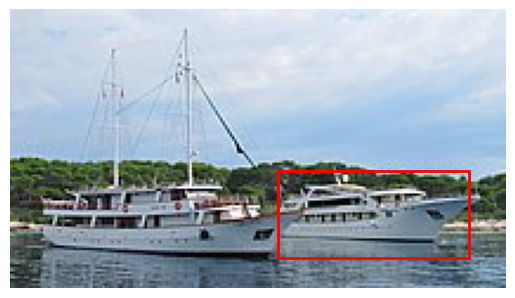

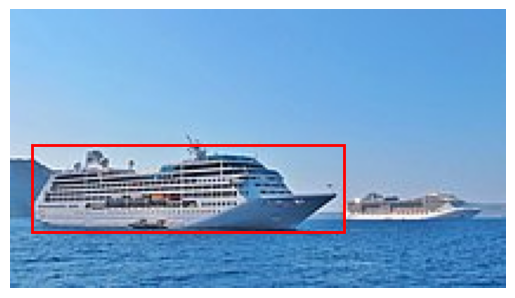

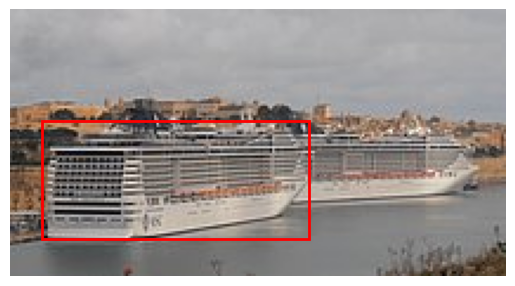

In [ ]:
display_images_with_annotations(df_1)

In [ ]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0
    return iou


In [ ]:
# Предположим, что у вас есть два bounding box'а в формате (x, y, width, height)
ground_truth_box = (10, 20, 50, 30)
predicted_box = (12, 18, 55, 32)

iou_score = calculate_iou(ground_truth_box, predicted_box)
print(f"IoU: {iou_score}")

IoU: 0.7912087912087912


## Валидатор для df_1 и df_2

In [ ]:
# Сравнение количества строк:
if df_1.shape[0] != df_2.shape[0]:
    raise ValueError("DataFrames do not have the same number of rows.")

In [ ]:
# Сравнение столбцов:
if set(df_1.columns) != set(df_2.columns):
    raise ValueError("DataFrames do not have the same columns.")

In [ ]:
# Проверка каждого столбца:
for col in df_1.columns:
    if df_1[col].dtype != df_2[col].dtype:
        raise ValueError("Column '{}' has different types.".format(col))

In [ ]:
# Сравнение значений:
if not (df_1 == df_2).all().all():
    raise ValueError("DataFrames contain different values.")

ValueError: DataFrames contain different values.